# HOME ASSIGNMENT #5: BIGQUERY SQL & PYTHON PANDAS

**Mục đích của bài Assignment**
> *  Upload Data từ Google Spreadsheet lên BigQuery và thao tác data với SQL
*  Thao tác với data bằng Pandas
*   `[Optional]` Data Visualization on Python

**Các kiến thức áp dụng**
* Slack API, JSON to DataFrame
* Google Spreadsheet to BigQuery
* SQL
* Python Pandas

**Lời Khuyên**
* Đây là bài tập nhẹ nhàng hơn các tuần trước
* Các bạn dành thời gian ôn lại và xâu chuỗi kiến thức

# TODO 1: BIGQUERY & SQL
* Làm theo Lab của Week 5: [HERE](https://anhdang.gitbook.io/datacracy/atom/5-sql-and-database-design/5.2-lab-upload-data-tu-google-sheet-to-bigquery)

In [29]:
# Import Library
import requests 
import re 
from datetime import datetime as dt 
from gspread_dataframe import set_with_dataframe 
import pandas as pd
import json 
from oauth2client.service_account import ServiceAccountCredentials 
import os
import numpy as np
import gspread

In [30]:
with open('../env_variable.json', 'r') as j:
    json_data = json.load(j)

In [32]:
os.environ['SLACK_BEARER_TOKEN'] = json_data['SLACK_BEARER_TOKEN']

In [33]:
# Code để pull Slack Data
# (1)List of Slack member
endpoint = "https://slack.com/api/users.list"
headers = {"Authorization": "Bearer {}".format(json_data['SLACK_BEARER_TOKEN'])}
response_json = requests.post(endpoint, headers=headers).json()
user_dat = response_json['members']

user_dict = {'user_id':[],'name':[],'display_name':[],'real_name':[],'title':[],'is_bot':[]}
for i in range(len(user_dat)):
    user_dict['user_id'].append(user_dat[i]['id'])
    user_dict['name'].append(user_dat[i]['name'])
    user_dict['display_name'].append(user_dat[i]['profile']['display_name'])
    user_dict['real_name'].append(user_dat[i]['profile']['real_name_normalized'])
    user_dict['title'].append(user_dat[i]['profile']['title'])
    user_dict['is_bot'].append(user_dat[i]['is_bot'])

user_df = pd.DataFrame(user_dict) 
user_df = user_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
user_df.head()

user_id               name       display_name           real_name  \
0    USLACKBOT           slackbot           Slackbot            Slackbot   
1  U01AT4T75JB     loclexuan26392        Loc Le Xuan         Loc Le Xuan   
2  U01AVDY7JET           locle.ds        Loc Le Xuan         Loc Le Xuan   
3  U01BE2PR6LU     maianhdang.ftu                MAD  Dặng Huỳnh Mai Anh   
4  U01C48T7S1J  huyenhoang.design  Thanh Huyen Hoang   Thanh Huyen Hoang   

                title  is_bot  
0                 NaN   False  
1                 NaN   False  
2                 NaN   False  
3  Technical Contents   False  
4                 NaN   False

In [34]:
# (2) LIST OF SLACK CHANNELS

endpoint2 = "https://slack.com/api/conversations.list"
data = {'types': 'public_channel,private_channel'} # -> CHECK: API Docs https://api.slack.com/methods/conversations.list/test
response_json = requests.post(endpoint2, headers=headers, data=data).json() 
channel_dat = response_json['channels']

channel_dict = {'channel_id':[], 'channel_name':[], 'is_channel':[],'creator':[],'created_at':[],'topics':[],'purpose':[],'num_members':[]}
for i in range(len(channel_dat)):
  channel_dict['channel_id'].append(channel_dat[i]['id'])
  channel_dict['channel_name'].append(channel_dat[i]['name'])
  channel_dict['is_channel'].append(channel_dat[i]['is_channel'])
  channel_dict['creator'].append(channel_dat[i]['creator'])
  channel_dict['created_at'].append(dt.fromtimestamp(float(channel_dat[i]['created'])))
  channel_dict['topics'].append(channel_dat[i]['topic']['value'])
  channel_dict['purpose'].append(channel_dat[i]['purpose']['value'])
  channel_dict['num_members'].append(channel_dat[i]['num_members'])

channel_df = pd.DataFrame(channel_dict) 
channel_df = channel_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
channel_df.head()

channel_id      channel_name  is_channel      creator          created_at  \
0  C01B4PVGLVB           general        True  U01BE2PR6LU 2020-09-23 17:25:03   
1  C01BYH7JHB5          contents        True  U01BE2PR6LU 2020-10-05 14:28:09   
2  C01CAMNCJJV   branding-design        True  U01AVDY7JET 2020-10-05 10:16:30   
3  C01U6P7LZ8F  atom-assignment1        True  U01BE2PR6LU 2021-04-17 14:00:04   
4  C01UL6K1C7L        atom-week1        True  U01BE2PR6LU 2021-04-17 00:44:32   

                                              topics  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Assigment#1 - Python Basics &amp; Spreadsheet ...   
4  TOPIC: Data Strategy. Metrics Design. Spreadsh...   

                                             purpose  num_members  
0  This is the one channel that will always inclu...           64  
1                                                NaN           12  
2                                                NaN            9  
3  Where learners submit assignments and give rev...           44  
4  TOPIC: Data Strategy. Metrics Design. Spreadsh...           43

In [35]:
# (3) LIST OF SLACK MESSAGES
endpoint3 = "https://slack.com/api/conversations.history"
msg_dict = {'channel_id':[],'msg_id':[], 'msg_ts':[], 'user_id':[], 'latest_reply':[],'reply_user_count':[],'reply_users':[],'github_link':[]}
for channel_id, channel_name in zip(channel_df['channel_id'], channel_df['channel_name']):
  print('Channel ID: {} - Channel Name: {}'.format(channel_id, channel_name))
  try:
    data = {"channel": channel_id} 
    response_json = requests.post(endpoint3, data=data, headers=headers).json()
    msg_ls = response_json['messages']
    for i in range(len(msg_ls)):
      if 'client_msg_id' in msg_ls[i].keys():
        msg_dict['channel_id'].append(channel_id)
        msg_dict['msg_id'].append(msg_ls[i]['client_msg_id'])
        msg_dict['msg_ts'].append(dt.fromtimestamp(float(msg_ls[i]['ts'])))
        msg_dict['latest_reply'].append(dt.fromtimestamp(float(msg_ls[i]['latest_reply'] if 'latest_reply' in msg_ls[i].keys() else 0))) ## -> No reply: 1970-01-01
        msg_dict['user_id'].append(msg_ls[i]['user'])
        msg_dict['reply_user_count'].append(msg_ls[i]['reply_users_count'] if 'reply_users_count' in msg_ls[i].keys() else 0)
        msg_dict['reply_users'].append(msg_ls[i]['reply_users'] if 'reply_users' in msg_ls[i].keys() else 0) 
        ## -> Censor message contains tokens
        text = msg_ls[i]['text']
        github_link = re.findall('(?:https?://)?(?:www[.])?github[.]com/[\w-]+/?', text)
        msg_dict['github_link'].append(github_link[0] if len(github_link) > 0 else np.nan)
  except:
    print('====> '+ str(response_json))

Channel ID: C01B4PVGLVB - Channel Name: general
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01BYH7JHB5 - Channel Name: contents
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01CAMNCJJV - Channel Name: branding-design
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01U6P7LZ8F - Channel Name: atom-assignment1
Channel ID: C01UL6K1C7L - Channel Name: atom-week1
Channel ID: C01ULCHGN75 - Channel Name: atom-general
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C020VMT58JK - Channel Name: topics-data-analytics
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C0213MNH9L6 - Channel Name: topics-python
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C0213N56M2A - Channel Name: topics-materials
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C021FSDN7LJ - Channel Name: atom-assignment2
Channel ID: C021KLB0DSB - Channel Name: discuss-group3
Channel ID: C021KLB90GP - Channel Name: discuss-group4
Channel ID: C0220

In [36]:
msg_df = pd.DataFrame(msg_dict)
msg_df = msg_df.replace('', np.nan) 
msg_df.tail()

channel_id                                msg_id  \
232  C023UJGMDND  8d52e739-7903-44a8-aa9b-150ce15d4b08   
233  C023UJGMDND  15096040-5001-4884-aeeb-92ee5bcad3e3   
234  C023UJGMDND  a8edeb55-8d76-4ea7-8ea0-3111840ffb44   
235  C0245PZUFSL  2ccae5b9-902c-4fff-bf08-e84d558537be   
236  C0245PZUFSL  a6e46b2c-00a6-43f3-acb2-9fb221d25d4b   

                        msg_ts      user_id        latest_reply  \
232 2021-06-02 23:10:19.007100  U01UMJ36QD9 1970-01-01 07:00:00   
233 2021-06-02 17:34:22.003500  U01UTGT8CVA 1970-01-01 07:00:00   
234 2021-05-30 08:55:42.001400  U01BE2PR6LU 1970-01-01 07:00:00   
235 2021-06-02 19:10:03.003400  U01BE2PR6LU 1970-01-01 07:00:00   
236 2021-06-02 19:09:43.003200  U01BE2PR6LU 1970-01-01 07:00:00   

     reply_user_count reply_users                     github_link  
232                 0           0  https://github.com/Quan030994/  
233                 0           0  https://github.com/ngttnguyen/  
234                 0           0  https://github.com/anhdanggit/  
235                 0           0                             NaN  
236                 0           0                             NaN

In [23]:
# (4) LIST OF DataCracy role
dtc_groups = pd.read_csv('../assignment_4\datacracy_groups.csv')
dtc_groups.head()

name DataCracy_role
0           slackbot            BTC
1     loclexuan26392            BTC
2           locle.ds            BTC
3     maianhdang.ftu            BTC
4  huyenhoang.design            BTC

In [45]:
# Code để upload data lên Gsheet
## Authorize bằng JSON
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '../GG API.json', scope)
gc = gspread.authorize(credentials)
print("DONE!")

DONE!


In [54]:
# ACCES GOOGLE SHEET
sheets = ['user','channel','messages','dtc_role']
df = [user_df,channel_df,msg_df,dtc_groups]
spreadsheet_key = '1GRB1Uz2D1-oYk1Wdqfeu2_cpcQFb2COLXZ-V33zv0JI' # input SPREADSHEET_KEY HERE
sh = gc.open_by_key(spreadsheet_key)
for i in range(len(sheets)):
    worksheet = sh.get_worksheet(i)
    set_with_dataframe(worksheet, df[i])
    print('done')

done
done
done
done


Link Gsheet: https://docs.google.com/spreadsheets/d/1GRB1Uz2D1-oYk1Wdqfeu2_cpcQFb2COLXZ-V33zv0JI/edit#gid=2033140842

# TODO 2: Python Pandas
[Kaggle](https://www.kaggle.com/) là cộng đồng lớn nhất thế giới về Data Science với các cuộc thi/thử thách ML, các công cụ và tài liệu để học và phát triển kỹ năng
* Tạo account của bạn trên Kaggle
* Coi tutorial và làm 6 sets bài tập trên Kaggle [HERE](https://www.kaggle.com/learn/pandas)
* Bạn có thể làm bài trực tiếp trên Kaggle (cũng là dạng notebook online như Colab). Toàn bộ notebook sẽ lưu trên phần Code trong Profile Account của bạn
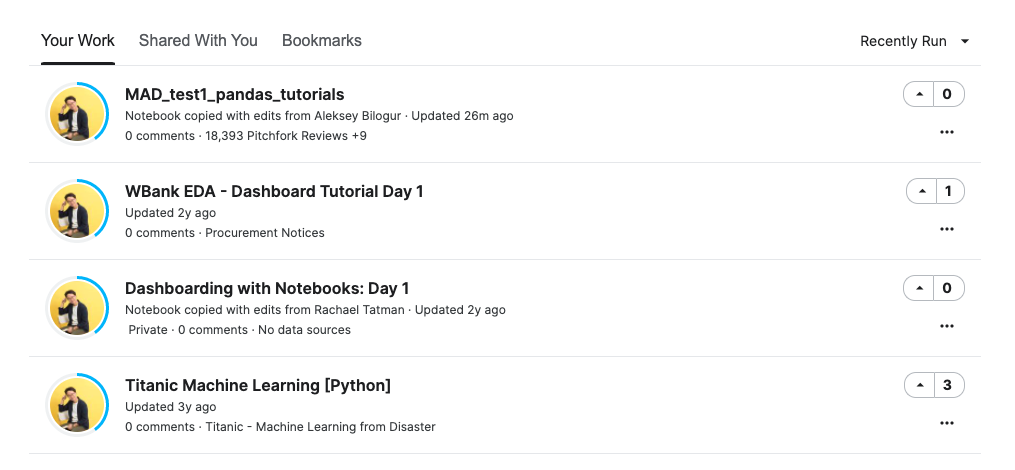

In [3]:
# Copy các link Kaggle sau:
## 1. Link tới Kaggle Account của bạn -----> 
## 2. Link tới các bài tập
## Pandas 1: ---> https://www.kaggle.com/hanguyen1476/exercise-creating-reading-and-writing
## Pandas 2: ---> https://www.kaggle.com/hanguyen1476/exercise-indexing-selecting-assigning
## Pandas 3: ---> https://www.kaggle.com/hanguyen1476/exercise-summary-functions-and-maps
## Pandas 4: ---> https://www.kaggle.com/hanguyen1476/exercise-grouping-and-sorting
## Pandas 5: ---> https://www.kaggle.com/hanguyen1476/exercise-data-types-and-missing-values
## Pandas 6: ---> https://www.kaggle.com/hanguyen1476/exercise-renaming-and-combining

# TODO 3: Python Pandas 
Trở lại TODO7 [Assignment#4](https://github.com/anhdanggit/atom-assignments/blob/main/assignment_4/home_assignment_4.ipynb) (nếu bạn chưa hoàn thành)

In [63]:
msg_channel = pd.merge(msg_df, channel_df, how='left', on='channel_id')
user_dtc = pd.merge(user_df, dtc_groups, how='left', on='name')
master_df = pd.merge(msg_channel, user_dtc, how='left', on='user_id')

In [69]:
# Lấy danh sách learner đã nộp bài trong channel assignment
df = master_df.loc[(master_df.github_link.notnull()) & (master_df['channel_name'].str.startswith('atom-assignment')) & (master_df['DataCracy_role'].str.startswith('Learner'))]
df.head(1)

channel_id                                msg_id  \
1  C01U6P7LZ8F  D86A48D2-D953-4504-92BF-D9240B2549A8   

                      msg_ts      user_id               latest_reply  \
1 2021-05-10 11:51:46.004700  U01UJ9LG5U5 2021-05-15 16:14:31.003600   

   reply_user_count                 reply_users                  github_link  \
1                 2  [U01USGKQ771, U01V00KHHHP]  https://github.com/danhpcv/   

       channel_name  is_channel  ...          created_at  \
1  atom-assignment1        True  ... 2021-04-17 14:00:04   

                                              topics  \
1  Assigment#1 - Python Basics &amp; Spreadsheet ...   

                                             purpose num_members     name  \
1  Where learners submit assignments and give rev...          44  danhpcv   

  display_name  real_name title is_bot  DataCracy_role  
1    Danh Phan  Danh Phan   NaN  False     Learner_Gr3  

[1 rows x 21 columns]

In [70]:
# 2. Learners nào nộp bài sớm nhất trong Assignment 1, 2, 3?
sub_min=df.groupby('channel_name').apply(lambda df: df.loc[df.msg_ts.idxmin()])
sub_min[['user_id','display_name','DataCracy_role', 'msg_ts','github_link' ]]

user_id          display_name DataCracy_role  \
channel_name                                                         
atom-assignment1  U01UMJ5AQ0K   Dương Phan Nam Hưng    Learner_Gr1   
atom-assignment2  U01UQGZHSTZ             Toan Tran    Learner_Gr2   
atom-assignment3  U01UTGRMGEQ      Nguyen Hong Hanh    Learner_Gr4   
atom-assignment4  U01UJ9M3P1T  Cao Nguyen Huy Hoang    Learner_Gr2   
atom-assignment5  U01UTGT8CVA    Nguyễn Thảo Nguyên    Learner_Gr3   

                                     msg_ts  \
channel_name                                  
atom-assignment1 2021-04-21 13:00:34.000800   
atom-assignment2 2021-05-12 22:50:48.004000   
atom-assignment3 2021-05-16 19:08:08.018900   
atom-assignment4 2021-05-26 00:46:52.015200   
atom-assignment5 2021-06-02 17:34:22.003500   

                                             github_link  
channel_name                                              
atom-assignment1    https://github.com/duongphannamhung/  
atom-assignment2        https://github.com/toantran2206/  
atom-assignment3  https://github.com/nguyenhonghanh2511/  
atom-assignment4         https://github.com/cnhhoang850/  
atom-assignment5          https://github.com/ngttnguyen/

In [71]:
# 3. Learners nào nộp bài trễ nhất trong Assignment 1, 2, 3?
sub_min=df.groupby('channel_name').apply(lambda df: df.loc[df.msg_ts.idxmax()])
sub_min[['user_id','display_name','DataCracy_role', 'msg_ts','github_link' ]]

user_id      display_name DataCracy_role  \
channel_name                                                     
atom-assignment1  U01UJ9LG5U5         Danh Phan    Learner_Gr3   
atom-assignment2  U01UTGRMGEQ  Nguyen Hong Hanh    Learner_Gr4   
atom-assignment3  U01USGKQ771             Trang    Learner_Gr1   
atom-assignment4  U01UTGVPE7N          ntp-hoai    Learner_Gr3   
atom-assignment5  U01V00JK9LH    Đình Tuấn Phạm    Learner_Gr2   

                                     msg_ts  \
channel_name                                  
atom-assignment1 2021-05-10 11:51:46.004700   
atom-assignment2 2021-05-22 12:39:34.015500   
atom-assignment3 2021-05-27 22:30:16.003200   
atom-assignment4 2021-06-03 01:28:09.011900   
atom-assignment5 2021-06-03 00:16:49.007800   

                                             github_link  
channel_name                                              
atom-assignment1             https://github.com/danhpcv/  
atom-assignment2  https://github.com/nguyenhonghanh2511/  
atom-assignment3        https://github.com/TrangNgo1709/  
atom-assignment4             https://github.com/hoaintp/  
atom-assignment5  https://github.com/phamdinhtuan200382/

# TODO 4 (OPTIONAL): Python Data Viz
Coi tutorial và làm nhiều nhất có thể các sets bài tập trên [Kaggle Data Visualization](https://www.kaggle.com/learn/data-visualization)

In [ ]:
# Copy Link tới các bài tập
## DataViz 1: --->
## DataViz 2: --->
## DataViz 3: --->
## DataViz 4: --->
## DataViz 5: --->
## DataViz 6: --->
## DataViz 7: --->